In [1]:
import tensorflow as tf
# tf.enable_eager_execution()
import src.infovae as infovae
from src.utils import input_fn

import numpy as np
import matplotlib.pyplot as plt

/home/act65/anaconda3/envs/mri/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
ds = input_fn(50)
iterator = ds.make_one_shot_iterator()
img, t = iterator.get_next()
init_op = iterator.make_initializer(ds)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/MNIST_data/train-labels-idx1-ubyte.gz
Extracting /tmp/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting /tmp/MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [3]:
nn = infovae.InfoVAE(2, 16, 4)

In [4]:
emb = tf.layers.flatten(infovae.reparameterise(nn.encoder(img), 2, 0.0))

In [5]:
saver = tf.train.Saver()
model_path = '/media/act65/640a4914-fb27-4b69-acc6-2a2d569c900b/infovae/2dims/0/'

In [6]:
def run(x, n):  
    with tf.Session() as sess:
        saver.restore(sess, tf.train.latest_checkpoint(model_path))
        results = [sess.run(x) for _ in range(n)]
    return tuple(np.vstack(r) for r in zip(*results))

In [7]:
embeddings, labels = run([emb, t], 100)

INFO:tensorflow:Restoring parameters from /media/act65/640a4914-fb27-4b69-acc6-2a2d569c900b/infovae/2dims/0/infovae_saver.ckpt


In [8]:
# overwrite embeddings with the ones from the data
emb = tf.constant(embeddings)

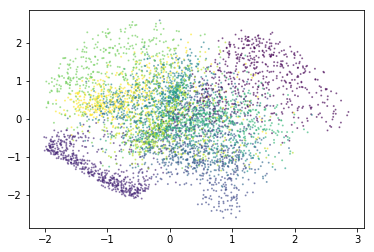

In [9]:
plt.scatter(embeddings[:, 0], 
            embeddings[:, 1], 
            s=1, alpha=0.5, c=list(labels[:, 0]))

In [10]:
def gaussian_kernel(x, emb, temp=1.0):
    x = tf.expand_dims(x, 1)
    emb = tf.expand_dims(emb, 0)
    return (1/tf.sqrt(2*tf.constant(np.pi))) * tf.exp(-0.5*tf.reduce_sum((x-emb)**2, axis=[2])/temp)

def px(x, kernel, emb):
    h = tf.layers.flatten(infovae.reparameterise(nn.encoder(x), 2, 0.0))
    z = kernel(h, emb)
    return tf.reduce_mean(kernel(h, emb), axis=[1])

In [22]:
temp = 0.0005
kernel = lambda x, y: gaussian_kernel(x, y, temp)
p_rnd = px(tf.random_normal((50, 32, 32, 1)), kernel, emb)

In [23]:
p = px(img, kernel, emb)

In [24]:
P_rnd, P = run([p_rnd, p], 100)

INFO:tensorflow:Restoring parameters from /media/act65/640a4914-fb27-4b69-acc6-2a2d569c900b/infovae/2dims/0/infovae_saver.ckpt


(array([-0.0001,  0.    ,  0.0001,  0.0002,  0.0003,  0.0004,  0.0005,
         0.0006,  0.0007]), <a list of 9 Text xticklabel objects>)

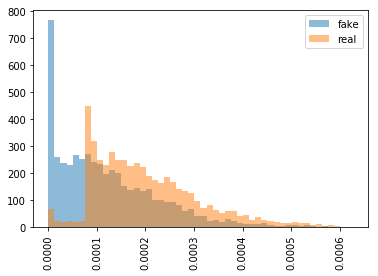

In [25]:
_, bins, _ = plt.hist(P_rnd.ravel(), bins=50, alpha=0.5, label='fake')
_ = plt.hist(P.ravel(), bins=bins, alpha=0.5, label='real')
plt.legend()
plt.xticks(rotation=90)

In [26]:
# want to pick the max temp that;
# doesnt shatter the gradients (aka still smooth)
# as smooth as possible
# while giving a separation between noise and the data.

In [31]:
d = 50
x = np.linspace(-3, 3, d)
y = np.linspace(-3, 3, d)
X, Y = np.meshgrid(x, y)

In [32]:
Z = tf.constant(np.stack([X.ravel(), Y.ravel()], axis=1), dtype=tf.float32)
p_grid = tf.reduce_mean(kernel(Z, emb), axis=[1])
dp_grid = tf.gradients(p_grid, Z)[0]

In [33]:
P_grid, dP_grid = run([p_grid, dp_grid], 1)

INFO:tensorflow:Restoring parameters from /media/act65/640a4914-fb27-4b69-acc6-2a2d569c900b/infovae/2dims/0/infovae_saver.ckpt


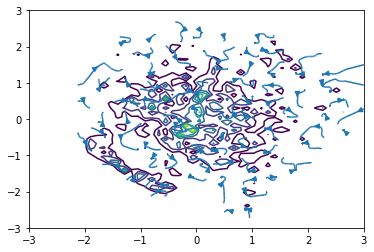

In [34]:
plt.contour(X, Y, P_grid.reshape((d, d)))
plt.streamplot(X, Y, 
               dP_grid[:, 0].reshape((d,d)), 
               dP_grid[:, 1].reshape((d,d)),
               density=0.5)

In [ ]:
# what are we looking for here?
# smooth structure in the estimates of p(x).
# but how smooth!?

# want the directions to be meaningful.